# Group 6 Assignment

* Members: Michał Butkiewicz, ChiaYu Lin, Daumantas Patapas, Marcel Stelte
* Institution: Vrije Universiteit Amserdam

This notebook will present and discuss the code used to retrieve data from the social media platforms Twitter and Sina Weibo.

## General Code

This section will describe the code snippets that are used in various places across this notebook, and are not specific to a singular subtopic. Before anything else the following packages are required throughout this assignment, so please make sure they are installed:

In [45]:
import os
import datetime
import json
import requests

import matplotlib.pyplot as plt
import pandas as pd

from bluebird import BlueBird
from urllib.parse import quote
from prettytable import PrettyTable
from collections import Counter

To make the crawled data reusable at a later point in time it was decided that the results of the crawl should be persisted in files, so that it could be used later on. For this it needs to be checked if a fitting directory already exists, or if it has to be created. The function for this is depicted below. It checks if a folder called "data" exists within the location in which this notebook will be executed, and creates such a directory if it does not exist yet. The same goes for the subfolder that can can be passed as a parameter, which allows different subdirectories for different crawlers to be created.

In [46]:
def init_directories(sub_path: str):
    db_path = f"{os.path.dirname(os.path.abspath(''))}/data/"

    if not os.path.exists(db_path):
        os.mkdir(db_path)

    if not os.path.exists(f"{db_path}{sub_path}"):
        os.mkdir(f"{db_path}{sub_path}")

The next utility functions focus in formatting datetimes. Since it is necessary to limit the retrieved data to a specific time frame, the creation date and time retrieved by both crawlers needs to be parsed into a datetime object, which can then be compared to previously specified datetime objects to evaluate if the current card is within the allowed timeframe.

The APIs used for this notebook return the datetime in the following format: "Sun Nov 07 02:17:19 +0800 2021". Since the month is not returned as a numerical object, first a function that parses the month into a numerical value is needed:

In [47]:
def parse_month_to_int(month: str) -> int:
    if month == 'Jan':
        return 1
    if month == 'Feb':
        return 2
    if month == 'Mar':
        return 3
    if month == 'Apr':
        return 4
    if month == 'May':
        return 5
    if month == 'Jun':
        return 6
    if month == 'Jul':
        return 7
    if month == 'Aug':
        return 8
    if month == 'Sep':
        return 9
    if month == 'Oct':
        return 10
    if month == 'Nov':
        return 11
    if month == 'Dec':
        return 12

Afterwards the rest of the retrieved datetime string needs to be processed:

In [48]:
def parse_creation_time_of_card(creation_time: str) -> datetime:
    (weekday, month, day, time, timezone, year) = creation_time.split(" ")
    (hour, minute, second) = time.split(":")
    if timezone[0:1] == "+":
        actual_timezone = datetime.timezone(datetime.timedelta(hours = int(timezone[1:]) / 100))
    elif timezone[0:1] == "-":
        actual_timezone = datetime.timezone(datetime.timedelta(hours = int(timezone[1:]) / -100))
    actual_creation_time = datetime.datetime(int(year), parse_month_to_int(month), int(day), int(hour), int(minute), int(second), 0, actual_timezone)

    return actual_creation_time

Besides those utility functions, the basic parameters for both crawlers need to be defined in this notebook environment, so that bouth crawlers have the same conditions. Fir this reason the start and end date, as well as the keywords to be crawled, are defined here:

In [49]:
start_date = datetime.datetime(2021, 9, 1, 0, 0, 0, 0, datetime.timezone(datetime.timedelta()))
end_date = datetime.datetime(2021, 12, 18, 23, 59, 59, 59, datetime.timezone(datetime.timedelta()))

searches = []
searches.append(["#F1阿布扎比大奖赛#", "AbuDhabiGP"])
searches.append(["#2021MLB世界大赛#", "WorldSeries"])
searches.append(["#短池世锦赛#", "FINAAbuDhabi2021"])
searches.append(["#PGC2021#", "PGC2021"])
searches.append(["#斯德哥尔摩major#", "PGLMAJOR"])
searches.append(["#2021英雄联盟全球总决赛#", "Worlds2021"])

## Sina Weibo Crawler

In this section the crawler for the Sina Weibo social media platform will be described.

The platform is most prominently used in China, therefore the searched keywords are in Chinese too. With only a Dutch phone number it is impossible to create a new account on Sina Weibo, which already prevents the usage of the API provided by Sina Weibo itself. Also if the website is accessed without an account the user will automatically be redirected to the front page. The only exception is the access through the mobile version of the website: https://m.weibo.cn. This version of the website has no restrictions regarding accounts or geolocation, and can therefore be used as a basis for the crawler.

Through research an already existing crawler was found: https://github.com/KaidiGuo/keyword_based_Sina_weibo_crawler. This crawler however was not maintained for several years and not functional anymore. It still gave insight in how to construct a working crawler for Sina Weibo using the mobile website. More specifically, this crawler accesses the API that is used as a data model for the mobile version of the platform: https://m.weibo.cn/api/.

Another source for this code was the following article: https://www.programmerall.com/article/49252020901/.

For the functionality of the crawler several utility functions are necessary, which will be explained first.

Since the keywords need to be represented in an URL string which is appended to the URL of the mobile API, certain characters need to be formatted differently. In the case of this project it was only necessary to do this for the "#" symbol, but the following method can easily be extended with further symbols:

In [50]:
def format_keyword_for_url(keyword: str) -> str:
    return keyword.replace("#", "%23")

The Sina Weibo mobile API returns posts in form of so-called cards. They are however not returned as a list but a tree with any number of branches on each node. To make them easier processable later on a function is provided that puts the cards into a list. There are also many cards that contain no actual posts but e.g. suggestions for users that might be interesting to the user, advertisements, etc., which are not relevant for this research and are therefore filtered from the list too.

The relevant numerical card_types represent the following cards:
* mblog: Contains a singuler post that can be added to the list
* card_group: Contains a list of cards that need to be analysed recursively
* left_- and right_element: Some cards are split horizontally and contain two "mblog" cards that can be added to the list

The following URL gives an example of how the posts are formatted in the API: https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%23%E8%8B%B1%E9%9B%84%E8%81%94%E7%9B%9F%23%23EDG%23. The cards 0 and 1 contain a card with a singular "mblog", which can be added to the list. Card 2 contains a "card_group", which in turn contains a card with a "mblog" and a card without a group or a post. Therefore only the first child of card 2 should be added to the list.

There is also a mechanism in place that stores the ID of each added card in a set. For each new card it will be checked whether that ID is already in the set or not. This mechanism prevents duplicate entries in the list of cards that could falsify the result.

In [51]:
def unpack_nested_cards(retrieved_cards: any, container_id: str, cur_page: int) -> set[any]:
    cards = []
    card_ids = set()

    for retrieved_card in retrieved_cards:

        json_card = json.loads(json.dumps(retrieved_card))

        if json_card.get("mblog"):
            card_id = json_card.get("mblog").get("id")
            if card_id not in card_ids:
                cards.append(json_card)
                card_ids.add(card_id)

        if json_card.get("card_group"):
            for card in unpack_nested_cards(retrieved_card["card_group"], container_id, cur_page):
                json_card = json.loads(json.dumps(card))
                card_id = json_card.get("mblog").get("id")
                if card_id not in card_ids:
                    cards.append(json_card)
                    card_ids.add(card_id)

        if json_card.get("left_element"):
            card_id = json_card.get("left_element").get("mblog").get("id")
            if card_id not in card_ids:
                cards.append(json_card.get("left_element"))
                card_ids.add(card_id)

        if json_card.get("right_element"):
            card_id = json_card.get("right_element").get("mblog").get("id")
            if card_id not in card_ids:
                cards.append(json_card.get("right_element"))
                card_ids.add(card_id)

    return cards

With all those utility functions defined we can now combine the into a singular function that initiates a crawl of a single keyword. The function will first define the url and the header with the user agent that has to be passed to that url. There is also a page counter in place, since the API returns the cards split over multiple pages. After each run it will be checked if the lates page contained any cards, if not the function will end looping through them. For each page an HTML request is sent to the API, and the returned card tree will be parsed and filtered with the previously mentioned methods. Finally all cards will be stored in a text file in JSON format.

In [52]:
def crawl_weibo(keyword: str, start_date: datetime, end_data: datetime, file_name: str):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'
    }
    url = "https://m.weibo.cn/api/container/getIndex?"
    
    cur_page = 0
    data_retrieved = True
    json_list = []

    init_directories("weibo")

    print(f"Currently crawling {keyword}...")

    while data_retrieved:
        cur_page += 1

        #https://m.weibo.cn/api/container/getIndex?containerid=

        data = {
            'containerid': f'100103type%3D1%26q%3D{format_keyword_for_url(keyword)}',
            'page_type':' searchall',
            'page': cur_page,
        }
        html = requests.get(url, headers=headers, params=data)

        if html.content:
            response = html.json()
            cards = response["data"]["cards"]
            if str(cards) != "[]":
                try:
                    for card in unpack_nested_cards(cards, data["containerid"], cur_page):
                        json_card = json.loads(json.dumps(card))
                        creation_time = parse_creation_time_of_card(json_card.get("mblog").get("created_at"))
                        if creation_time >= start_date and creation_time <= end_data:
                            json_list.append(json_card)
                except Exception as e:
                    print(e)
            else:
                data_retrieved = False
        
    with open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{file_name}.json", "w", encoding="utf-8") as file:
        json.dump(json_list, file, ensure_ascii=False, indent=4)
    file.close()
    print(f"Found {len(json_list)} relevant cards.")

Now to execute all this list of keywords and output file names is set up together with a start and end date. For each element of the keyword list the crawl_method will be called, and the results for the given timeframe will be stored in a file with the given name:

In [53]:
for search in searches:
    crawl_weibo(search[0], start_date, end_date, search[1])

Currently crawling #F1阿布扎比大奖赛#...
Found 667 relevant cards.
Currently crawling #2021MLB世界大赛#...
Found 113 relevant cards.
Currently crawling #短池世锦赛#...
Found 195 relevant cards.
Currently crawling #PGC2021#...
Found 563 relevant cards.
Currently crawling #斯德哥尔摩major#...
Found 313 relevant cards.
Currently crawling #2021英雄联盟全球总决赛#...
Found 233 relevant cards.


## Twitter Crawler

In this section the crawler for Twitter will be described. The shortcomings of this method but also the lack of alternatives to our hand are discussed in the actual paper. The structure of this section will be different to the previous one, since only the already existing BlueBird library found with the following URL is used: https://github.com/labteral/bluebird.

Since the BlueBird library is using API v2, but for this project API v1.1 was planned to be used, modifications were made to the original library, mostly regarding to which and how parameters are passed between methods. The changes are the following:

* The parameter "mode" had to be changed to "API_1_1"
* The used base url had to be slightly changed
* The parameters for the API now also include "'f': 'live'"
* The parameters of the search method were tweaked several times to figure out how many tweets can be retrieved
* A print statement was removed from _encode_query since Jupyter can't handle too many of them well

The changes were implemented through overriding the respective methods in a new inheriting class:

In [54]:
class ModifiedBlueBird(BlueBird):
    def __init__(self):
        super().__init__()

    @staticmethod
    def _encode_query(query) -> str:
        encoded_query = ''

        since = None
        if 'since' in query:
            since = query['since']

        until = None
        if 'until' in query:
            until = query['until']

        near = None
        if 'near' in query:
            near = query['near']

        lang = None
        if 'lang' in query:
            lang = query['lang']

        fields = []
        if 'fields' in query:
            fields = query['fields']

        for field in fields:
            target = None
            if 'target' in field:
                target = field['target']

            items = field['items']

            match = None
            if 'match' in field:
                match = field['match']

            exact = False
            if 'exact' in field:
                exact = field['exact']

            if exact:
                marginal_query = '"' + '" "'.join(items) + '"'
            else:
                target = None
                if 'target' in field:
                    target = field['target']

                if target == 'from':
                    marginal_query = 'from:' + ' from:'.join(items)
                elif target == 'to':
                    marginal_query = 'to:' + ' to:'.join(items)
                elif target == 'hashtag':
                    marginal_query = '#' + ' #'.join(items)
                elif target == 'mention':
                    marginal_query = '@' + ' @'.join(items)
                else:
                    marginal_query = ' '.join(items)

            if match == 'any':
                marginal_query = ' OR '.join(marginal_query.split())
            elif match == 'none':
                marginal_query = '-' + ' -'.join(marginal_query.split())

            if match == 'any':
                encoded_query += ' (' + marginal_query + ')'
            else:
                encoded_query += ' ' + marginal_query

        if since is not None:
            encoded_query += f' since:{since}'

        if until is not None:
            encoded_query += f' until:{until}'

        if near is not None:
            encoded_query += f' near:"{near[0]}" within:{near[1]}mi'

        encoded_query = encoded_query.strip()
        encoded_query = quote(encoded_query)

        if lang is not None:
            encoded_query += f'&l={lang}'
        
        # print(f'[Test URL] https://twitter.com/search?f=tweets&vertical=default&q={encoded_query}')
        return encoded_query

    def _search_1_1(self, query, deep, count, sleep_time, min_tweets):
        #if count > 100:
        #    count = 100

        encoded_query = ModifiedBlueBird._encode_query(query)

        base_url = 'https://api.twitter.com/1.1/search/tweets.json'
        params = {
            'q': encoded_query,
            'count': count,
            'result_type': 'recent',
            'include_entities': 'false'
        }
        url = ModifiedBlueBird._update_url_with_params(base_url, params)
        yield from self._get_tweets_1_1(url, deep, sleep_time, min_tweets)

    def search(self, query, deep=False, count=1000, sleep_time=0, min_tweets=0, mode=BlueBird.API_1_1):
        return getattr(self, f'_search_{mode}')(query, deep, count, sleep_time, min_tweets)

The modified library needs to be invoked with the correct query parameters to crawl for the recent tweets for those keywords. Due to the Twitter API being limited to the most recent tweets, it is unfortunately not possible to get more data. More on those issues can be found in the research paper. In the below example the "search" method is used. If instead the "stream" method would be used, more tweets could be found, but it also creates an infinite loop that does not interact well with the Jupyter notebook environment.

In [55]:
query = {
    'fields': [
        {'items': ['tbd'], 'target': 'hashtag'}
    ],
    'since': str(start_date.date()),
    'until': str(end_date.date())
}

init_directories("twitter")

for search in searches:
    print(f"Currently crawling {search[1]}...")
    file = open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{search[1]}.json", "w")
    query["fields"][0]["items"][0] = search[1]
    json_list = []
    tweet_ids = []

    for tweet in ModifiedBlueBird().search(query):
        if tweet['id'] not in tweet_ids:
            json_tweet = json.loads(json.dumps(tweet))
            json_list.append(json_tweet)
            tweet_ids.append(tweet['id'])
    
    json.dump(json_list, file, ensure_ascii=True, indent=4)
    file.close()
    print(f"Found {len(tweet_ids)} relevant tweets.")

Currently crawling AbuDhabiGP...
Found 100 relevant tweets.
Currently crawling WorldSeries...
Found 100 relevant tweets.
Currently crawling FINAAbuDhabi2021...
Found 100 relevant tweets.
Currently crawling PGC2021...
Found 100 relevant tweets.
Currently crawling PGLMAJOR...
Found 26 relevant tweets.
Currently crawling Worlds2021...
Found 100 relevant tweets.


## Evaluation & Plotting

In this section all the evaluatin and plotting done for this research will be described.

For the plotting the stored json files need to be reopened first:

In [56]:
sport_1_twitter = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{searches[0][1]}.json","r",encoding='utf-8'))
sport_2_twitter = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{searches[1][1]}.json","r",encoding='utf-8'))
sport_3_twitter = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{searches[2][1]}.json","r",encoding='utf-8'))
esport_1_twitter = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{searches[3][1]}.json","r",encoding='utf-8'))
esport_2_twitter = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{searches[4][1]}.json","r",encoding='utf-8'))
esport_3_twitter = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/twitter/{searches[5][1]}.json","r",encoding='utf-8'))

sport_1_weibo = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{searches[0][1]}.json","r",encoding='utf-8'))
sport_2_weibo = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{searches[1][1]}.json","r",encoding='utf-8'))
sport_3_weibo = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{searches[2][1]}.json","r",encoding='utf-8'))
esport_1_weibo = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{searches[3][1]}.json","r",encoding='utf-8'))
esport_2_weibo = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{searches[4][1]}.json","r",encoding='utf-8'))
esport_3_weibo = json.load(open(f"{os.path.dirname(os.path.abspath(''))}/data/weibo/{searches[5][1]}.json","r",encoding='utf-8'))

Now a function for basic user data received from Twitter will be implemented, that will be used later on.

In [57]:
def research_twitter(dataset):
    result=[]
    result.append([ status['retweet_count'] for status in dataset ])
    result.append([ status['created_at'] for status in dataset ])
    result.append([ status['user']['location'] for status in dataset if len(status['user']['location'])>0])
    result.append([ status['lang'] for status in dataset ])
    result.append([ status['user']['followers_count'] for status in dataset ])
    result.append([ status['favorite_count'] for status in dataset ])
    return result

A similar function is implemented for Sina Weibo:

In [116]:
def research_weibo(dataset):
    result=[]
    result.append([ status['mblog']['reposts_count'] for status in dataset ])
    result.append([ status['mblog']['created_at'] for status in dataset ])
    result.append([ int(float(status['mblog']['user']['followers_count'].replace("\u4e07",""))*1000) for status in dataset ])
    result.append([ status['mblog']['attitudes_count'] for status in dataset ])
    return result

The number of retrieved posts and tweets was already counted upon retrieval, but they are bundled again below:

In [59]:
print("Number of tweets from Twitter:")
print("#AbuDhabiGP: ", len(sport_1_twitter))
print("#WorldSeries: ", len(sport_2_twitter))
print("#FINAAbuDhabi2021: ", len(sport_3_twitter))
print("#PGC2021: ", len(esport_1_twitter))
print("#PGLMAJOR: ", len(esport_2_twitter))
print("#Worlds2021: ", len(esport_3_twitter))
print("")
print("Number of posts from Sina Weibo:")
print("#F1阿布扎比大奖赛#: ", len(sport_1_weibo))
print("#2021MLB世界大赛#: ", len(sport_2_weibo))
print("#短池世锦赛#: ", len(sport_3_weibo))
print("#PGC2021#: ", len(esport_1_weibo))
print("#斯德哥尔摩major#: ", len(esport_2_weibo))
print("#2021英雄联盟全球总决赛#: ", len(esport_3_weibo))

Number of tweets from Twitter:
#AbuDhabiGP:  100
#WorldSeries:  100
#FINAAbuDhabi2021:  100
#PGC2021:  100
#PGLMAJOR:  26
#Worlds2021:  100

Number of posts from Sina Weibo:
#F1阿布扎比大奖赛#:  667
#2021MLB世界大赛#:  113
#短池世锦赛#:  195
#PGC2021#:  563
#斯德哥尔摩major#:  313
#2021英雄联盟全球总决赛#:  233


### Twitter language analysis

Now the most commonly used locations and languages were evaluated. This was only possible for Twitter, since Sina Weibo does not provide such data. The following method was used to evaluate the data and format it in a table:

In [60]:
def loclang_tables(dataset):
    for label, data in (('Location', research_twitter(dataset)[2]), ('Language', research_twitter(dataset)[3])):
        pt = PrettyTable(field_names=[label, 'Count'])
        c = Counter(data)
        [ pt.add_row(kv) for kv in c.most_common()[:10] ]
        pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
        print(pt) 

The results for #AbuDhabiGP:

In [67]:
loclang_tables(sport_1_twitter)

+--------------------------------+-------+
| Location                       | Count |
+--------------------------------+-------+
| Monterrey, Nuevo León          |     2 |
| Nairobi, Africa                |     1 |
| Durmiendo 😴                   |     1 |
| Campbeltown, Scotland          |     1 |
| Sydney, New South Wales        |     1 |
| Comunidad de Madrid, España    |     1 |
| Que les importa                |     1 |
| Bilbo                          |     1 |
| 19  she/her mv1ln4msc47sv5sp11 |     1 |
| Greenock, Scotland             |     1 |
+--------------------------------+-------+
+----------+-------+
| Language | Count |
+----------+-------+
| en       |    65 |
| es       |    29 |
| pt       |     2 |
| ja       |     2 |
| und      |     2 |
+----------+-------+


The results for #WorldSeries:

In [68]:
loclang_tables(sport_2_twitter)

+---------------------------------+-------+
| Location                        | Count |
+---------------------------------+-------+
| Chicago, IL                     |     9 |
| New Smyrna Beach, Florida       |     5 |
| Atlanta, GA                     |     3 |
| Connecticut, USA                |     2 |
| Mississauga, Ontario, Canada    |     2 |
| LA, CA                          |     1 |
| Los Angeles                     |     1 |
| Nashville, TN                   |     1 |
| Rural Hall, North Carolina, USA |     1 |
| Charlotte, NC/Stankonia         |     1 |
+---------------------------------+-------+
+----------+-------+
| Language | Count |
+----------+-------+
| en       |    96 |
| und      |     2 |
| es       |     2 |
+----------+-------+


The results for #FINAAbuDhabi2021:

In [69]:
loclang_tables(sport_3_twitter)

+---------------------+-------+
| Location            | Count |
+---------------------+-------+
| Tuscaloosa, AL      |     6 |
| France              |     5 |
| Tiverton, Devon     |     4 |
| Ashland, OH         |     4 |
| she/her             |     2 |
| Charlottesville, VA |     2 |
| Roma                |     2 |
| College Station, TX |     2 |
| Italia              |     2 |
| Raleigh, NC         |     2 |
+---------------------+-------+
+----------+-------+
| Language | Count |
+----------+-------+
| en       |    78 |
| it       |    15 |
| fr       |     4 |
| ja       |     2 |
| es       |     1 |
+----------+-------+


The results for #PGC2021:

In [70]:
loclang_tables(esport_1_twitter)

+------------------------+-------+
| Location               | Count |
+------------------------+-------+
| she/her                |     2 |
| YeojaUnion¡♡           |     2 |
| Malaysia               |     2 |
| Brasil                 |     2 |
| Gamer  Follows You     |     1 |
| he/him                 |     1 |
| São Paulo, Brasil      |     1 |
| bangvelvet • aripink   |     1 |
| ENTP 9w8 5w4 4w3 so/sx |     1 |
| nondating              |     1 |
+------------------------+-------+
+----------+-------+
| Language | Count |
+----------+-------+
| ko       |    74 |
| en       |    23 |
| pt       |     2 |
| es       |     1 |
+----------+-------+


The results for #PGLMAJOR:

In [71]:
loclang_tables(esport_2_twitter)

+--------------------------+-------+
| Location                 | Count |
+--------------------------+-------+
| North Korea              |     1 |
| everything will be ok 🖤 |     1 |
| Österreich               |     1 |
| Hualien County, Taiwan   |     1 |
| Sus, France              |     1 |
| pune                     |     1 |
| Razgrad, Bulgaria        |     1 |
+--------------------------+-------+
+----------+-------+
| Language | Count |
+----------+-------+
| en       |    22 |
| pt       |     4 |
+----------+-------+


The results for #Worlds2021:

In [72]:
loclang_tables(esport_3_twitter)

+-----------------------------+-------+
| Location                    | Count |
+-----------------------------+-------+
| United States               |     2 |
| Bulgaria                    |     1 |
| La Roche-sur-Foron, France  |     1 |
| Haute-Savoie, Rhône-Alpes   |     1 |
| London                      |     1 |
| LEJOS DE ESTE PAIS ... SIII |     1 |
| North America               |     1 |
| Swansea - UK, All my mixes⬇ |     1 |
| Germany                     |     1 |
| Birbia                      |     1 |
+-----------------------------+-------+
+----------+-------+
| Language | Count |
+----------+-------+
| en       |    56 |
| und      |    21 |
| es       |     7 |
| fr       |     6 |
| pt       |     4 |
| ja       |     3 |
| ko       |     2 |
| tl       |     1 |
+----------+-------+


### Esports vs sports analysis

Now the differences between sports and esports will be discussed. For this functions for plotting are implemented.

Firstly a function is provided that allows to create a dataset from any source, based on a given index of a tag in the JSON file. It returns either the sum or the mean value of the numbers in the dataset.

In [129]:
def create_dataset(method, topic_index, mode) -> list[any]:
    source = method.__name__.split("_")[1]

    sport_1_return = method(eval(f"sport_1_{source}"))[topic_index]
    sport_2_return = method(eval(f"sport_2_{source}"))[topic_index]
    sport_3_return = method(eval(f"sport_3_{source}"))[topic_index]
    esport_1_return = method(eval(f"esport_1_{source}"))[topic_index]
    esport_2_return = method(eval(f"esport_2_{source}"))[topic_index]
    esport_3_return = method(eval(f"esport_3_{source}"))[topic_index]

    if mode == "sum":
        dataset = [
            ["sport", "#AbuDhabiGP", sum(sport_1_return)],
            ["sport", "#WorldSeries", sum(sport_2_return)],
            ["sport", "#FINAAbuDhabi2021", sum(sport_3_return)],
            ["esport", "#PGC2021", sum(esport_1_return)],
            ["esport", "#PGLMAJOR", sum(esport_2_return)],
            ["esport", "#Worlds2021", sum(esport_3_return)],
        ]
    elif mode == "avg":
        dataset = [
            ["sport", "#AbuDhabiGP", round(sum(sport_1_return)/len(sport_1_return), 2)],
            ["sport", "#WorldSeries", round(sum(sport_2_return)/len(sport_2_return), 2)],
            ["sport", "#FINAAbuDhabi2021", round(sum(sport_3_return)/len(sport_3_return), 2)],
            ["esport", "#PGC2021", round(sum(esport_1_return)/len(esport_1_return), 2)],
            ["esport", "#PGLMAJOR", round(sum(esport_2_return)/len(esport_2_return), 2)],
            ["esport", "#Worlds2021", round(sum(esport_3_return)/len(esport_3_return), 2)],
        ]

    return dataset

The next function uses that data to draw a plot:

In [131]:
def plot(topic_index, source, title, mode):
    data = create_dataset(source, topic_index, mode)

    dataframe = pd.DataFrame(data, columns=["Type", "Event", "Count"])
    colors = ['#BB0000' if i == "sport" else '#0000BB' for i in dataframe['Type']]
    ax = dataframe.plot(x="Event", y="Count", kind="bar",figsize=(10,7), color=colors, legend=False, title=title, rot=20)
    ax.set(xlabel="Events", ylabel="Count")
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()

Now we can use those functions to draw plots, e. g. the number of retweets or reposts per keyword, the number of likes/attitudes, or the number of followers of the posting user.

NOTE: Please bear in mind that the data for twitter is not as accurate if you rerun it, as it can only retrieve the data of the last few days. Also note the in this notebook we couldn't run the optimal version of the twitter crawler, as described earlier. Therefore the following plots might differ from the research paper.

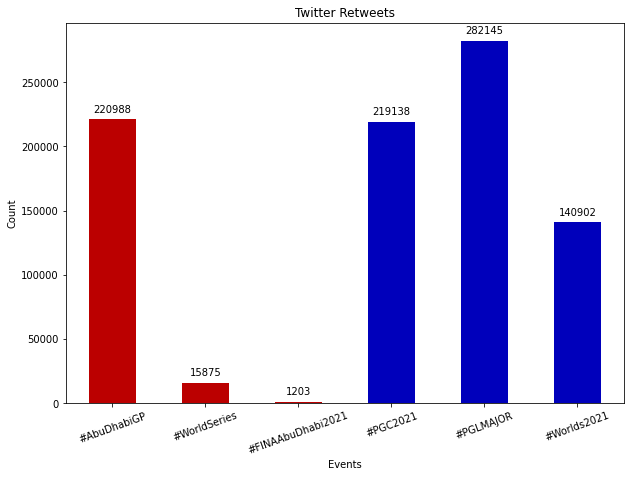

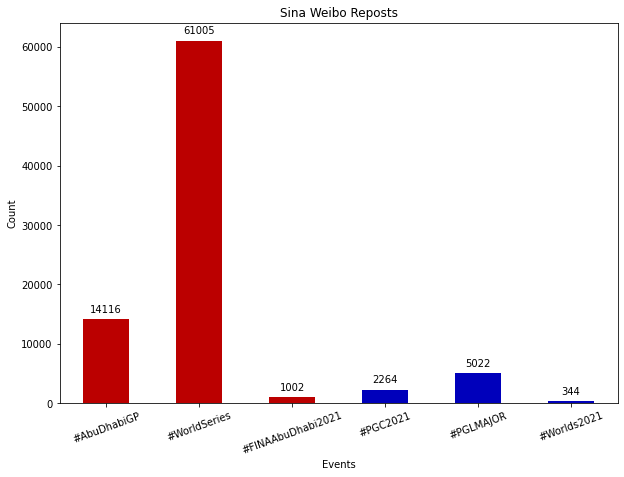

In [123]:
plot(0, research_twitter, "Twitter Retweets", "sum")
plot(0, research_weibo, "Sina Weibo Reposts", "sum")

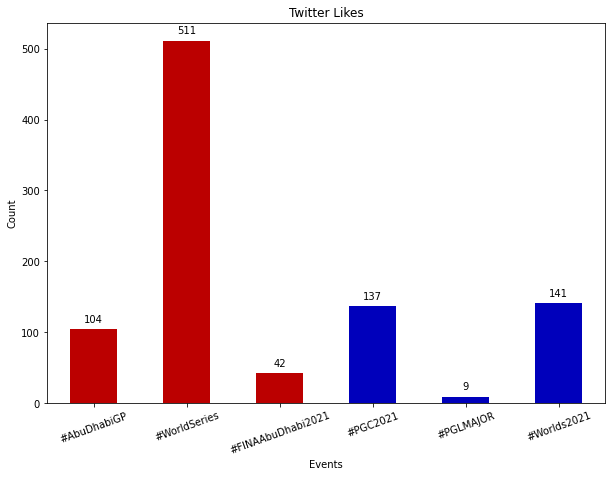

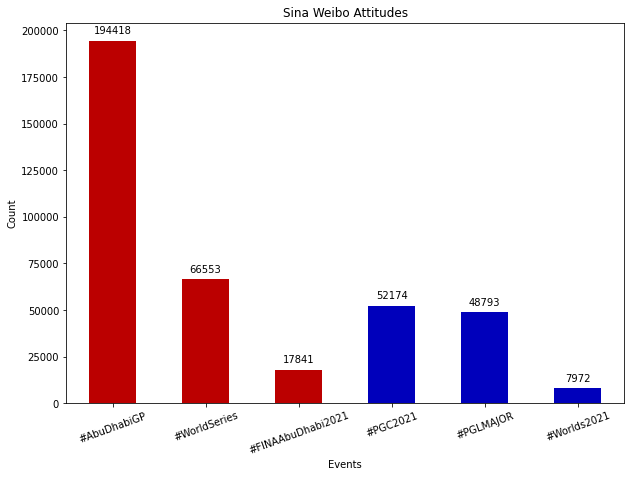

In [125]:
plot(5, research_twitter, "Twitter Likes", "sum")
plot(3, research_weibo, "Sina Weibo Attitudes", "sum")

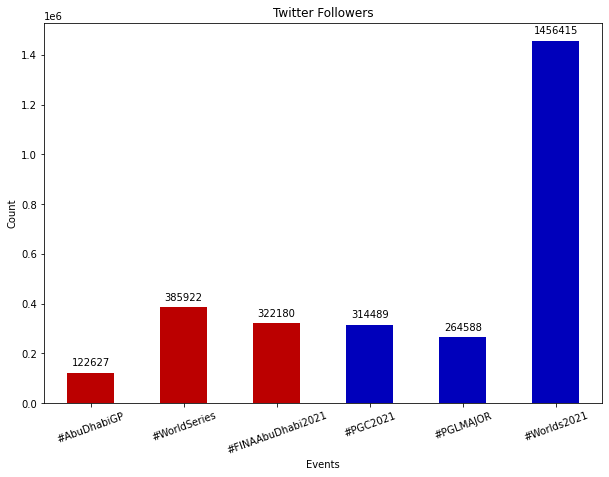

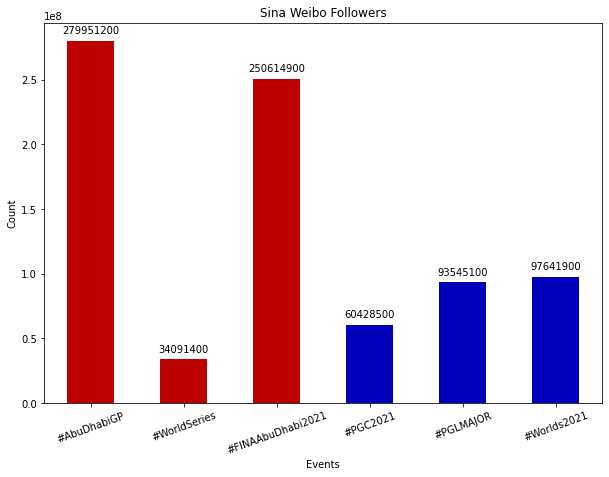

In [124]:
plot(4, research_twitter, "Twitter Followers", "sum")
plot(2, research_weibo, "Sina Weibo Followers", "sum")

Since the above numbers might be heavily carried by some very big accounts, it is also reasonable to have a look at the average numbers of those metrics:

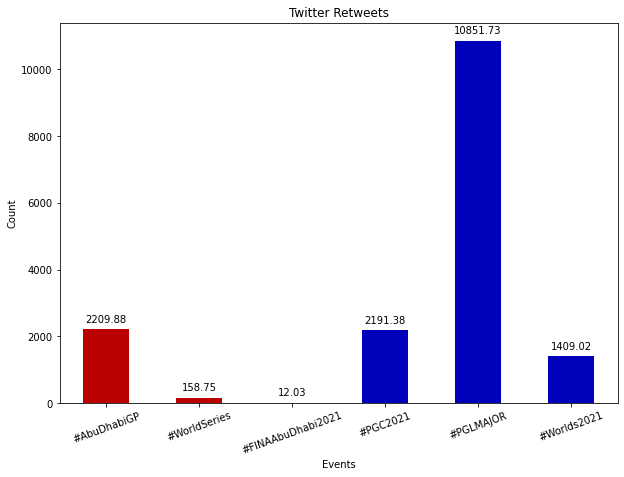

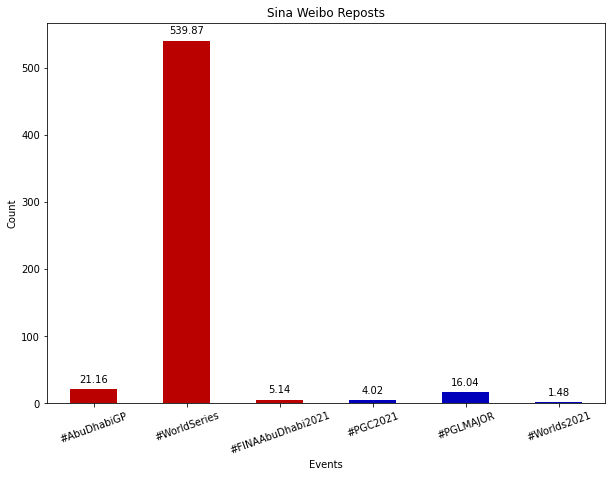

In [132]:
plot(0, research_twitter, "Twitter Retweets", "avg")
plot(0, research_weibo, "Sina Weibo Reposts", "avg")

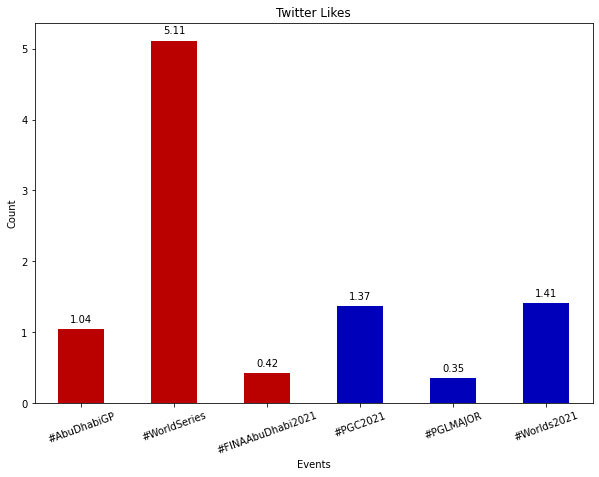

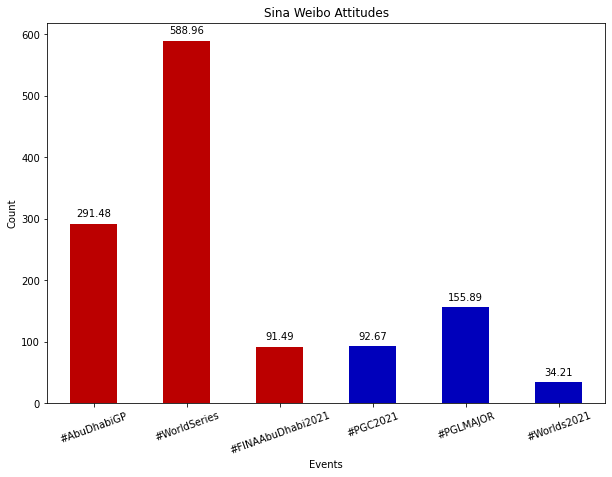

In [133]:
plot(5, research_twitter, "Twitter Likes", "avg")
plot(3, research_weibo, "Sina Weibo Attitudes", "avg")

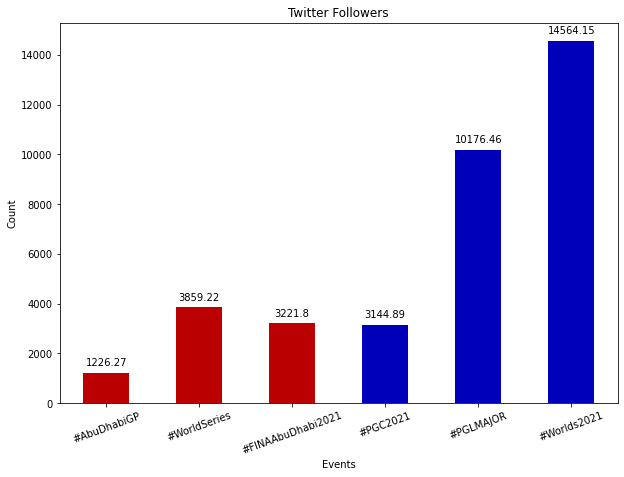

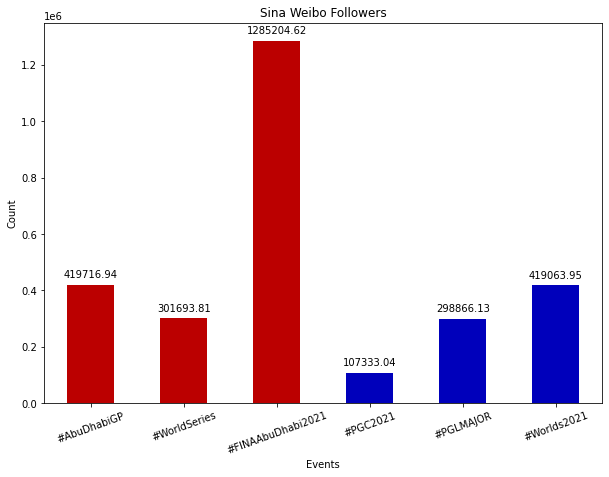

In [134]:
plot(4, research_twitter, "Twitter Followers", "avg")
plot(2, research_weibo, "Sina Weibo Followers", "avg")